In [1]:
import torch
from train import netG, my_transforms, unnormalize_functional, mean, std, device, to_rgb
from models import unnormalize_to
from PIL import Image
import torchvision.transforms.functional as TF
from IPython.display import SVG, display
import svgwrite
from cairosvg import svg2png

C:\Users\Simon\Anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
netG.load_state_dict(torch.load(r".\checkpoints\2021-11-15-19.08.27\210000__1.4482669830322266.pt")['G'])
netG.to(device)
netG.eval()
pass

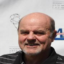

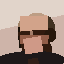

In [3]:
input_image = Image.open(r"C:\projects\data\celeba_val\main\008189.jpg")
input_tensor = my_transforms(input_image).to(device)
display(TF.to_pil_image(unnormalize_functional(input_tensor, mean, std)))
netG.return_mode = "bitmap"
output_image = to_rgb(netG(input_tensor.unsqueeze(0)).squeeze(0))
display(TF.to_pil_image(unnormalize_functional(output_image, mean, std)))

netG.return_mode = "shapes"
output_image_args = netG(input_tensor.unsqueeze(0)).squeeze(0).detach().cpu()

In [49]:
def save_svg(shapes_args, filename, canvas_height=500, canvas_width=500):
    dwg = svgwrite.Drawing(filename, profile='tiny', size=(canvas_width, canvas_height))
    r, g, b = 255*(mean.cpu() + std.cpu())
    bgr_color = svgwrite.rgb(r, g, b)
    dwg.add(dwg.rect(insert=(0, 0), size=(canvas_width, canvas_height), fill=bgr_color))

    mr, mg, mb = mean
    sr, sg, sb = std

    for shape_args in shapes_args:
        _, _, pos_x, pos_y, width, height, angle, squareness, r, g, b = shape_args
        pos_x = float(pos_x*canvas_height)
        pos_y = float(pos_y*canvas_width)
        height = float(height*canvas_height)
        width = float(width*canvas_width)
        width, height = height, width
        pos_x, pos_y = pos_y, pos_x
        angle = 180*float(angle)
        rgb = unnormalize_to(torch.stack([r, g, b]), -1.5, 1.5).view(-1, 1, 1)
        r, g, b = 255*unnormalize_functional(rgb, mean.cpu(), std.cpu()).view(-1)
        fill = svgwrite.rgb(r, g, b)
        if squareness > 0.5:
            shape = dwg.rect(insert=(pos_x-width, pos_y-height), size=(2*width, 2*height), fill=fill)
        else:
            shape = dwg.ellipse(center=(pos_x, pos_y), r=(width, height), fill=fill)
        shape.rotate(angle=angle, center=(pos_x, pos_y))
        dwg.add(shape)
    dwg.save()

    display(SVG(filename="./out.svg"))

In [10]:
from pathlib import Path
from tqdm.notebook import tqdm

input_path = Path(r"C:\projects\data\celeba/img_align_celeba/")
output_path = Path("./highres_outputs/") / (input_path.parent.name + "_pred")
output_path.mkdir(exist_ok=True, parents=True)

files = list(input_path.iterdir())

netG.return_mode = "shapes"

for file in tqdm(files):
    png_path = output_path / (file.stem + ".png")
    if png_path.exists():
        continue
    svg_path = output_path / (file.stem + ".svg")
    input_image = Image.open(file)
    input_tensor = my_transforms(input_image).to(device)
    output_image_args = netG(input_tensor.unsqueeze(0)).squeeze(0).detach().cpu()
    save_svg(output_image_args, svg_path, canvas_height=1080, canvas_width=1080)
    with open(svg_path, mode="rb") as svg_file:
        svg2png(bytestring=svg_file.read(), write_to=str(png_path))
    svg_path.unlink()

  0%|          | 0/202599 [00:00<?, ?it/s]

In [66]:
from pathlib import Path
from tqdm.notebook import tqdm
import tables
import tempfile
import torchvision.utils as vutils
import numpy as np

input_path = Path(r"G:\Simon\Documents\programming\github\shapenet2\progress\2021-11-17-16.42.48\batch_outputs.h5")
output_path = Path("./highres_outputs/animated") / (input_path.parent.name + "_pred")
output_path.mkdir(exist_ok=True, parents=True)

f = tables.open_file(str(input_path), mode='r')
nrows = f.root.batches.nrows
# batches = torch.tensor(f.root.batches)
indices = get_indices(nrows)[:-1]
batches = torch.tensor(np.stack([f.root.batches[i] for i in indices]))

for i, batch in enumerate(tqdm(batches)):
    output_file_path = output_path / (str(i) + ".png")
    if output_file_path.exists():
        continue
    with tempfile.TemporaryDirectory() as temp_dir:
        torch_bitmaps = []
        for j, sample in enumerate(batch):
            temp_path = Path(temp_dir)
            svg_path = temp_path / (str(j) + ".svg")
            save_svg(sample, svg_path, canvas_height=256, canvas_width=256)
            png_path = temp_path / (str(j) + ".png")
            with open(svg_path, mode="rb") as svg_file:
                svg2png(bytestring=svg_file.read(), write_to=str(png_path))
            torch_bitmap = TF.to_tensor(Image.open(png_path))
            torch_bitmaps.append(torch_bitmap)
        grid = vutils.make_grid(torch.stack(torch_bitmaps), normalize=True)
        vutils.save_image(grid, output_file_path)

  0%|          | 0/141 [00:00<?, ?it/s]

In [53]:
def get_indices(nrows):
    # nrows = 145196
    max_step = 1000
    steps = []
    items = [0]
    i = 0

    def r_sigmoid(x, b):
        if x < 0: return 0
        if x > 1: return 1
        return 1 / (1 + ((x / (1 - x)) + 1e-8)**(-b))

    while items[-1] < nrows:
        last_item = items[-1]
        step = 1 + max_step * r_sigmoid(10*(last_item/nrows), b = 1.6)
        new_item = last_item + round(step)
        items.append(new_item)
        steps.append(step)
        i += 1

    return items

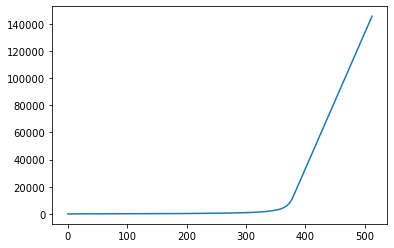

In [47]:
import matplotlib.pyplot as plt

plt.plot(items)

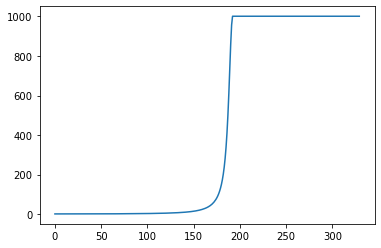

In [38]:
plt.plot(steps)

In [70]:
p = Path(r"C:\projects\data\celeba_val\main")
ims = torch.stack([
    TF.to_tensor(TF.resize(Image.open(p), size=(256, 256))) 
    for p in list(p.iterdir())[:16]
])
grid = vutils.make_grid(ims)
TF.to_pil_image(grid).save("faces.png")

In [100]:
h, w = 4, 10
repeats = 2

my_tensor = torch.randint(0, 10, [h, w])
print("my_tensor:", my_tensor)

repeated_1 = my_tensor.repeat_interleave(2, -2)
print("repeated_1:", repeated_1)

repeated_2 = my_tensor.view(h, 1, w).expand(h, repeats, w).contiguous().view(-1, w)
print("repeated_2:", repeated_2)

my_tensor: tensor([[7, 6, 8, 5, 5, 2, 2, 1, 2, 8],
        [4, 0, 3, 2, 8, 4, 5, 9, 3, 1],
        [3, 3, 3, 1, 3, 3, 2, 4, 6, 5],
        [0, 4, 8, 7, 7, 7, 3, 4, 6, 9]])
repeated_1: tensor([[7, 6, 8, 5, 5, 2, 2, 1, 2, 8],
        [7, 6, 8, 5, 5, 2, 2, 1, 2, 8],
        [4, 0, 3, 2, 8, 4, 5, 9, 3, 1],
        [4, 0, 3, 2, 8, 4, 5, 9, 3, 1],
        [3, 3, 3, 1, 3, 3, 2, 4, 6, 5],
        [3, 3, 3, 1, 3, 3, 2, 4, 6, 5],
        [0, 4, 8, 7, 7, 7, 3, 4, 6, 9],
        [0, 4, 8, 7, 7, 7, 3, 4, 6, 9]])
repeated_2: tensor([[7, 6, 8, 5, 5, 2, 2, 1, 2, 8],
        [7, 6, 8, 5, 5, 2, 2, 1, 2, 8],
        [4, 0, 3, 2, 8, 4, 5, 9, 3, 1],
        [4, 0, 3, 2, 8, 4, 5, 9, 3, 1],
        [3, 3, 3, 1, 3, 3, 2, 4, 6, 5],
        [3, 3, 3, 1, 3, 3, 2, 4, 6, 5],
        [0, 4, 8, 7, 7, 7, 3, 4, 6, 9],
        [0, 4, 8, 7, 7, 7, 3, 4, 6, 9]])


In [102]:
import time

h, w = 400, 1000
repeats = 200

my_tensor = torch.randint(0, 10, [h, w])

start_time = time.perf_counter()
repeated_1 = my_tensor.repeat_interleave(repeats, -2)
elapsed = time.perf_counter() - start_time
print("repeated_1:", )
print("time:", elapsed)

start_time = time.perf_counter()
repeated_2 = my_tensor.view(h, 1, w).expand(h, repeats, w).contiguous().view(-1, w)
elapsed = time.perf_counter() - start_time
print("repeated_2:", )
print("time:", elapsed)

repeated_1:
time: 0.0017039000013028271
repeated_2:
time: 0.1595871999998053


tensor([[7, 5, 7, 3, 6, 8, 3, 0, 5, 8],
        [7, 5, 7, 3, 6, 8, 3, 0, 5, 8],
        [8, 1, 7, 0, 0, 1, 9, 9, 9, 4],
        [8, 1, 7, 0, 0, 1, 9, 9, 9, 4],
        [2, 2, 6, 9, 5, 7, 5, 9, 4, 3],
        [2, 2, 6, 9, 5, 7, 5, 9, 4, 3],
        [6, 5, 0, 8, 9, 9, 4, 6, 1, 2],
        [6, 5, 0, 8, 9, 9, 4, 6, 1, 2]])